In [1]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import plot_loss
from torch import optim
from tqdm.notebook import trange

from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer

from tensorboardX import SummaryWriter

torch.cuda.empty_cache()

In [2]:
import sys

In [3]:
sys.path

['/afs/cern.ch/user/a/adpetre/public/MEMFlow/notebooks/unfolding_flow',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/itk',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/python',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/lib',
 '',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos9-gcc11-opt/lib/python39.zip',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos9-gcc11-opt/lib/python3.9',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos9-gcc11-opt/lib/python3.9/lib-dynload',
 '/afs/cern.ch/user/a/adpetre/public/myenv/lib/python3.9/site-packages',
 '/afs/cern.ch/user/a/adpetre/public/zuko',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/IPython/extensions',
 '/afs/cern.ch/user/a/adpetre/.ipython

# Config


In [4]:
sys.path

['/afs/cern.ch/user/a/adpetre/public/MEMFlow/notebooks/unfolding_flow',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/itk',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/python',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/lib',
 '',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos9-gcc11-opt/lib/python39.zip',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos9-gcc11-opt/lib/python3.9',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos9-gcc11-opt/lib/python3.9/lib-dynload',
 '/afs/cern.ch/user/a/adpetre/public/myenv/lib/python3.9/site-packages',
 '/afs/cern.ch/user/a/adpetre/public/zuko',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/IPython/extensions',
 '/afs/cern.ch/user/a/adpetre/.ipython

In [11]:
from omegaconf import OmegaConf

config = {
    "name": "initial_tests",
    "version": "v2",
    
    "description": "",
    "input_dataset": "../../../dataset/v7",
    "input_shape": {
        "number_jets": 15,
        "jets_features": 5,
        "number_lept": 1,
        "lepton_features": 3
    },
    "conditioning_transformer":{
        "out_features": 32,
        "nhead": 1,
        "no_layers": 3
    },
    "unfolding_flow":{
        "nfeatures": 10,
        "ncond": 34,
        "ntransforms": 5,
        "hidden_mlp": [128]*4,
        "bins": 32,
        "autoregressive": True
    },
    "training_params":
    {
        "lr": 1e-5,
        "batch_size": 2048,
        "batch_size_training": 2048,
        "batch_size_validation": 512,
        "nepochs": 5,
        "traning_sample": 500000,
        "validation_sample": 69993
    }
}

conf = OmegaConf.create(config)

with open(f"runs/config_{conf.name}_{conf.version}.yaml", "w") as fo:
    fo.write(OmegaConf.to_yaml(conf))

# Setup the flow

In [12]:
import zuko

In [13]:
from zuko.flows import TransformModule, SimpleAffineTransform
from zuko.distributions import BoxUniform

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
class MyEnsemble(nn.Module):
    def __init__(self, no_jets, no_lept, jets_features, lepton_features, 
                 nfeatures_flow=12, ncond_flow=34, ntransforms_flow=5, hidden_mlp_flow=[128]*4, bins_flow=16,
                 autoregressive_flow=True, out_features_cond=32, nhead_cond=4, no_layers_cond=3, dtype=torch.float64):
        super(MyEnsemble, self).__init__()
        
        # pass no_jets and no_lept after passing data
        self.cond_transformer = ConditioningTransformerLayer(
                                            no_jets = no_jets,
                                            jets_features=jets_features, 
                                            no_lept = no_lept,
                                            lepton_features=lepton_features, 
                                            out_features=out_features_cond,
                                            nhead=nhead_cond,
                                            no_layers=no_layers_cond,
                                            dtype=dtype)      
        
        self.flow = zuko.flows.NSF(features=nfeatures_flow,
                              context=ncond_flow, 
                              transforms=ntransforms_flow, 
                              bins=bins_flow, 
                              hidden_features=hidden_mlp_flow, 
                              randperm=False,
                              base=BoxUniform,
                              base_args=[torch.ones(nfeatures_flow)*(-1),torch.ones(nfeatures_flow)], 
                              univariate_kwargs={"bound": 1 }, # Keeping the flow in the [-1,1] box.
                              passes= 2 if not autoregressive_flow else nfeatures_flow)

        self.flow.transforms.insert(0, SimpleAffineTransform(0*torch.ones(nfeatures_flow),1*torch.ones(nfeatures_flow),
                                                     -1*torch.ones(nfeatures_flow), 1*torch.ones(nfeatures_flow)))
        
        
    def forward(self, data):
        
        
        (data_ps, data_ps_detjacinv, mask_lepton, data_lepton, mask_jets,
        data_jets, mask_met, data_met,
        mask_boost_reco, data_boost_reco) =  data
            
        cond_X = self.cond_transformer(data_jets,
                                    data_lepton,
                                    data_met,
                                    data_boost_reco, 
                                    mask_jets, 
                                    mask_lepton, 
                                    mask_met, 
                                    mask_boost_reco)

        flow_result = self.flow(cond_X).log_prob(data_ps)
        detjac = data_ps_detjacinv.log()
        logp_g =  flow_result # + detjac 

        return logp_g, cond_X, flow_result, detjac

In [10]:
batch_size = conf.training_params.batch_size
device = torch.device('cuda')

data_cuda = DatasetCombined(conf.input_dataset, dev=device, dtype=torch.float64)

dataiterator = DataLoader(data_cuda, batch_size=batch_size, shuffle=True, drop_last=True)

jets file already exists
lepton_reco file already exists
met file already exists
boost file already exists
partons file already exists
lepton_partons file already exists
boost file already exists
H_thad_tlep_ISR file already exists
H_thad_tlep_ISR_cartesian file already exists


## Training loop

In [16]:
nepochs = conf.training_params.nepochs
lr_init = conf.training_params.lr
version = conf.version

name_dir = f'runs/{version}'
writer = SummaryWriter(name_dir)

In [26]:
train_subset, val_subset = torch.utils.data.random_split(
        data_cuda, [conf.training_params.traning_sample, conf.training_params.validation_sample],
        generator=torch.Generator().manual_seed(1))

In [27]:
# just reload it, don't call again DatasetCombined
#dataiterator = DataLoader(dataset=data_cuda, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=conf.training_params.batch_size_training)
val_loader = DataLoader(dataset=val_subset, shuffle=True, batch_size=conf.training_params.batch_size_validation)

In [28]:
model = MyEnsemble(no_jets=conf.input_shape.number_jets,
                    no_lept=conf.input_shape.number_lept,
                    jets_features=conf.input_shape.jets_features,
                    lepton_features=conf.input_shape.lepton_features, 
                    nfeatures_flow=conf.unfolding_flow.nfeatures,
                    ncond_flow=conf.unfolding_flow.ncond, 
                    ntransforms_flow=conf.unfolding_flow.ntransforms,
                    hidden_mlp_flow=conf.unfolding_flow.hidden_mlp, 
                    bins_flow=conf.unfolding_flow.bins,
                    autoregressive_flow=conf.unfolding_flow.autoregressive, 
                    out_features_cond=conf.conditioning_transformer.out_features, 
                    nhead_cond=conf.conditioning_transformer.nhead, 
                    no_layers_cond=conf.conditioning_transformer.no_layers,
                    dtype=torch.float64).cuda()

optimizer = optim.Adam(list(model.parameters()) , lr=lr_init)

#decay = 0.01
#fcn = lambda step: 1./(1. + decay*step)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=fcn)

plotter = plot_loss.LossPlotter(["loss_epoch","loss"])

#print(f"parameters flow:{count_parameters(model.flow)}, parameters conditioner: {count_parameters(model.cond_transformer_lambda)}")
print(f"parameters total:{count_parameters(model)}")

parameters total:1302351


In [29]:
torch.autograd.set_detect_anomaly(True)

In [30]:
scaler = torch.cuda.amp.GradScaler()

In [ ]:
N_train = len(train_loader)
N_valid = len(val_loader)
N_points = 5


for e in range(nepochs):
    
    sum_loss = 0.
    
    # training loop
    steps = trange(0, N_train, desc="Step", leave=True)
    
    print("Before training loop")
    for i, data in enumerate(train_loader):
        
        if (i % 100 == 0):
            print(i)
            
        print(i)
            
        optimizer.zero_grad()
        
        logp_g, cond_X, flow_result, detjac = model(data)
        # save # of nans per batch
        nan_mask = torch.isnan(logp_g)
        nonzeros = torch.count_nonzero(nan_mask)
        writer.add_scalar("Number_NaN_probabilities", nonzeros.item(), i)
        
        # save # of nans from flow_result
        nan_mask_flow = torch.isnan(flow_result)
        nonzeros_flow = torch.count_nonzero(nan_mask_flow)
        writer.add_scalar("Number_NaN_FlowLogOnly", nonzeros_flow.item(), i)
        
         # save # of nans from detJac
        nan_mask_det = torch.isnan(detjac)
        nonzeros_det = torch.count_nonzero(nan_mask_det)
        writer.add_scalar("Number_NaN_DetJacLogOnly", nonzeros_det.item(), i)
        
        # same verifies where infinities appear

        
        logp_g = torch.nan_to_num(logp_g, posinf=20, neginf=-20)
        flow_result = torch.nan_to_num(flow_result, posinf=20, neginf=-20)
        detjac = torch.nan_to_num(detjac, posinf=20, neginf=-20)
        
        flow_result_mean = -flow_result.nanmean()
        detjac_mean = -detjac.nanmean()
        writer.add_scalar("FlowLogOnly", flow_result_mean.item(), i)
        writer.add_scalar("detJacOnly", detjac_mean.item(), i)

        loss = -logp_g.nanmean()
        loss.backward()
        
        optimizer.step() 
        sum_loss += loss.item()
        
        writer.add_scalar("Loss_step_train", loss.item(), i)
        #steps.set_description(f"Step loss: {loss.item()}")

    writer.add_scalar('Loss_epoch_train', sum_loss/N_train, e)
    #epoch.set_description(sum_loss/N_train)
    valid_loss = 0
    
    # validation loop (don't update weights and gradients)
    print("Before validation loop")
    for i, data in enumerate(val_loader):
        
        logp_g, cond_X, flow_result, detjac = model(data)
        logp_g = torch.nan_to_num(logp_g, posinf=20, neginf=-20)
        loss =  -logp_g.nanmean()
        valid_loss += loss.item()
        
        writer.add_scalar("Loss_step_validation", loss.item(), i)
        
        if i == 0:
            
            (data_ps, data_ps_detjacinv, 
            mask_lepton, data_lepton, mask_jets,
            data_jets, mask_met, data_met,
            mask_boost_reco, data_boost_reco) =  data
            
            ps_new = model.flow(cond_X[0:500]).sample((N_points,))
            
            data_ps_cpu = data_ps[0:500].detach().cpu()
            ps_new_cpu = ps_new.detach().cpu()
            
            
            for x in range(data_ps_cpu.size(1)):
                fig, ax = plt.subplots()
                h = ax.hist2d(data_ps_cpu[:,x].tile(N_points,1,1).flatten().numpy(), # why that tile?
                              ps_new_cpu[:,:,x].flatten().numpy(),
                              bins=50, range=((0, 1),(0, 1)))
                fig.colorbar(h[3], ax=ax)
                writer.add_figure(f"Validation_ramboentry_{x}", fig, e)
        
        # aici
        
    writer.add_scalar('Loss_epoch_val', valid_loss/N_valid, e)
    
writer.close()

Step:   0%|          | 0/245 [00:00<?, ?it/s]

Before training loop
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
100
101
102
103
104
105
106
107
108
109
110
111


In [ ]:
for p in cond_transformer.parameters():
    print(p)
    


In [103]:
ps_new = flow(cond_X).sample((50,))

In [68]:
data_ps.shape

torch.Size([512, 10])

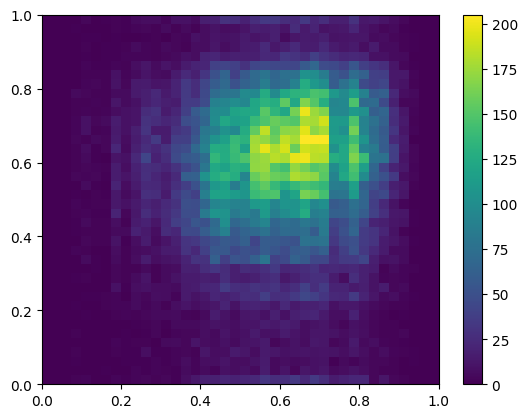

In [105]:
plt.hist2d(data_ps[:,-2:].unsqueeze(0).tile(50,1,1).flatten().numpy(), # why that tile?
           ps_new[:,:,-2:].flatten().numpy(), 
           bins=40, range=((0,1),(0,1)));
plt.colorbar()

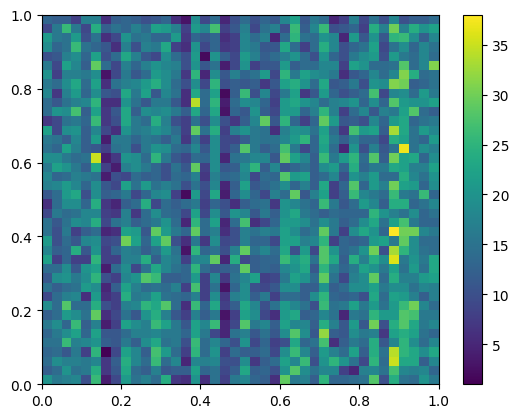

In [109]:
plt.hist2d(data_ps[:,7].unsqueeze(0).tile(50,1,1).flatten().numpy(), 
           ps_new[:,:,7].flatten().numpy(), 
           bins=40, range=((0,1),(0,1)));
plt.colorbar()

(array([  42.,   81.,  101.,  138.,  141.,  154.,  197.,  182.,  213.,
         221.,  247.,  244.,  251.,  238.,  278.,  288.,  263.,  280.,
         334.,  346.,  329.,  370.,  401.,  404.,  429.,  426.,  440.,
         429.,  504.,  523.,  542.,  578.,  604.,  615.,  656.,  680.,
         709.,  773.,  788.,  808.,  891.,  889.,  957., 1000., 1051.,
        1058., 1096., 1095., 1272., 1321., 1245., 1220., 1110., 1086.,
        1045.,  994.,  979.,  972.,  887.,  823.,  818.,  772.,  753.,
         701.,  646.,  647.,  597.,  614.,  492.,  543.,  495.,  509.,
         445.,  433.,  442.,  430.,  406.,  363.,  366.,  331.,  329.,
         302.,  342.,  253.,  288.,  263.,  270.,  232.,  248.,  184.,
         222.,  192.,  169.,  164.,  167.,  160.,  139.,   94.,   79.,
          42.]),
 array([-0.99332244, -0.97341674, -0.95351104, -0.93360535, -0.91369965,
        -0.89379395, -0.87388825, -0.85398255, -0.83407686, -0.81417116,
        -0.79426546, -0.77435976, -0.75445407, -0.734548

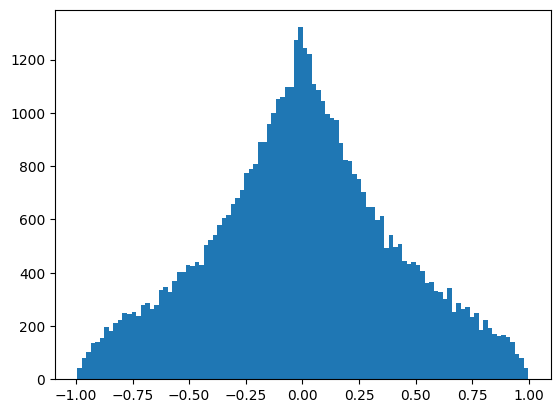

In [53]:
plt.hist((data_ps-ps_new).flatten(), bins=100)